In [1]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0qjuz7gx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-0qjuz7gx
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_A"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']


In [3]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 11169
Total validation images: 2898
Total test images: 3627
Total images in dataset: 17694


In [4]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 9928
Validation images (excluding 'random_occlusion'): 2576
Test images (excluding 'random_occlusion'): 3224
Total images (excluding 'random_occlusion'): 15728


In [5]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'random_occlusion', 'gaussian_noise', 'low_resolution', 'dirty_lens', 'original', 'chromatic_aberration', 'lens_flare', 'motion_blur', 'blur'}
Validation folders considered: {'random_occlusion', 'gaussian_noise', 'low_resolution', 'dirty_lens', 'original', 'chromatic_aberration', 'lens_flare', 'motion_blur', 'blur'}
Test folders considered: {'random_occlusion', 'gaussian_noise', 'low_resolution', 'dirty_lens', 'original', 'chromatic_aberration', 'lens_flare', 'motion_blur', 'blur'}


In [6]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']
Final Training images: 9928
Final Validation images: 2576
Final Test images: 3224
Total images after filtering: 15728


In [7]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'gaussian_noise', 'low_resolution', 'dirty_lens', 'original', 'chromatic_aberration', 'lens_flare', 'motion_blur', 'blur'}
Validation folders considered: {'gaussian_noise', 'low_resolution', 'dirty_lens', 'original', 'chromatic_aberration', 'lens_flare', 'motion_blur', 'blur'}
Test folders considered: {'gaussian_noise', 'low_resolution', 'dirty_lens', 'original', 'chromatic_aberration', 'lens_flare', 'motion_blur', 'blur'}


In [8]:
# First, install required packages
# !pip install git+https://github.com/openai/CLIP.git

import torch
import torch.nn as nn
import torch.nn.functional as F
import clip
from tqdm import tqdm
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import seaborn as sns
import random

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Classes with your exact format
classes = ['Batting', 'Bowling', 'Fielding', 'Umpire']

# Enhanced text prompts for all cricket actions
cricket_text_prompts = [
    "a cricket batsman hitting the ball with a bat",      # Batting
    "a cricket bowler delivering the ball to batsman",    # Bowling  
    "a cricket fielder catching or stopping the ball",   # Fielding
    "a cricket umpire making hand signals and decisions"  # Umpire
]

# Extended text descriptions for better training
cricket_action_descriptions = [
    # Batting descriptions
    [
        "a cricket batsman hitting the ball with a bat",
        "a cricket player in batting stance with bat raised",
        "a batsman playing a cricket shot",
        "a cricket batsman defending the wicket",
        "a cricket player batting in action during match"
    ],
    # Bowling descriptions  
    [
        "a cricket bowler delivering the ball to batsman",
        "a cricket bowler in bowling action",
        "a bowler running up to deliver in cricket",
        "a cricket bowler in follow through motion",
        "a fast bowler releasing the ball in cricket"
    ],
    # Fielding descriptions
    [
        "a cricket fielder catching the ball",
        "a cricket player fielding and stopping the ball", 
        "a fielder diving to catch in cricket",
        "a cricket fielder throwing the ball",
        "a wicket keeper behind stumps in cricket"
    ],
    # Umpire descriptions
    [
        "a cricket umpire making hand signals",
        "a cricket umpire giving decision in match",
        "an umpire signaling out in cricket",
        "a cricket referee making official decision",
        "an umpire in white coat during cricket match"
    ]
]

# =============================================================================
# DTYPE CONVERSION UTILITY
# =============================================================================

def convert_model_to_float32(model):
    """Convert all model parameters to float32"""
    return model.float()

# =============================================================================
# 1. ZERO-SHOT CLIP WITH ENHANCED TEXT PROMPTS
# =============================================================================

class ZeroShotCricketActionCLIP:
    def __init__(self, model_name="ViT-B/32"):
        self.device = device
        self.model, self.preprocess = clip.load(model_name, device=self.device)
        # Convert to float32 for consistency
        self.model = convert_model_to_float32(self.model)
        self.model.eval()
    
    def evaluate_dataset(self, test_loader, classes, text_prompts, show_samples=True, num_samples=8):
        """Evaluate cricket actions with zero-shot CLIP using custom text prompts"""
        print("🔍 Starting Zero-Shot Cricket Action Classification with Enhanced Text...")
        print(f"📋 Classes: {classes}")
        
        # Use provided text prompts
        self.text_tokens = clip.tokenize(text_prompts).to(self.device)
        
        all_preds = []
        all_targets = []
        sample_images = []
        sample_preds = []
        sample_targets = []
        sample_probs = []
        samples_collected = 0
        
        self.model.eval()
        
        with torch.no_grad():
            for batch_idx, (images, targets) in enumerate(tqdm(test_loader, desc="Zero-shot evaluation")):
                images = images.to(self.device)
                
                # Encode images and text
                image_features = self.model.encode_image(images)
                text_features = self.model.encode_text(self.text_tokens)
                
                # Normalize and calculate similarities
                image_features = F.normalize(image_features, dim=-1)
                text_features = F.normalize(text_features, dim=-1)
                
                logits = image_features @ text_features.T
                probs = F.softmax(logits, dim=-1)
                predictions = logits.argmax(dim=-1).cpu().numpy()
                
                all_preds.extend(predictions)
                all_targets.extend(targets.numpy())
                
                # Collect samples for visualization
                if show_samples and samples_collected < num_samples:
                    for i in range(images.size(0)):
                        if samples_collected < num_samples:
                            # Denormalize image for display
                            img = images[i].cpu()
                            mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
                            std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
                            img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
                            img = torch.clamp(img, 0, 1)
                            
                            sample_images.append(img)
                            sample_preds.append(predictions[i])
                            sample_targets.append(targets[i].item())
                            sample_probs.append(probs[i].cpu().numpy())
                            samples_collected += 1
        
        accuracy = accuracy_score(all_targets, all_preds)
        print(f"🎯 Zero-Shot Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print("📋 Zero-Shot Classification Report:")
        print(classification_report(all_targets, all_preds, target_names=classes, digits=4))
        
        # Display sample predictions
        if show_samples:
            self.display_predictions(sample_images, sample_targets, sample_preds, 
                                   sample_probs, classes, "Zero-Shot CLIP")
        
        return all_targets, all_preds, accuracy
    
    def display_predictions(self, images, true_labels, pred_labels, probs, classes, model_name):
        """Display sample predictions with ground truth"""
        num_samples = len(images)
        cols = 4
        rows = (num_samples + cols - 1) // cols
        
        plt.figure(figsize=(16, 4 * rows))
        plt.suptitle(f'{model_name} - Cricket Action Predictions\n'
                    f'Classes: {", ".join(classes)}', 
                    fontsize=16, fontweight='bold')
        
        for i in range(num_samples):
            plt.subplot(rows, cols, i + 1)
            
            # Convert tensor to numpy for display
            img_np = images[i].permute(1, 2, 0).numpy()
            plt.imshow(img_np)
            
            # Get prediction info
            true_class = classes[true_labels[i]]
            pred_class = classes[pred_labels[i]]
            confidence = probs[i][pred_labels[i]] * 100
            
            # Color code: green for correct, red for incorrect
            color = 'green' if true_labels[i] == pred_labels[i] else 'red'
            
            plt.title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%', 
                     color=color, fontweight='bold', fontsize=10)
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_cricket_predictions.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()

# =============================================================================
# 2. PRETRAINED CLIP WITH TEXT GUIDANCE (DTYPE FIXED)
# =============================================================================

class CricketActionCLIPWithText(nn.Module):
    def __init__(self, clip_model, num_classes, text_prompts, freeze_encoder=True):
        super().__init__()
        
        # IMPORTANT: Convert CLIP model to float32 first
        self.clip_model = convert_model_to_float32(clip_model)
        self.num_classes = num_classes
        
        if freeze_encoder:
            for param in self.clip_model.parameters():
                param.requires_grad = False
        
        # Pre-encode text prompts (now in float32)
        device = next(self.clip_model.parameters()).device
        text_tokens = clip.tokenize(text_prompts).to(device)
        
        with torch.no_grad():
            text_features = self.clip_model.encode_text(text_tokens)
            # Text features are now already float32
            self.register_buffer('text_features', F.normalize(text_features, dim=-1))
        
        # Get image feature dimension
        with torch.no_grad():
            dummy_image = torch.randn(1, 3, 224, 224).to(device)
            image_features = self.clip_model.encode_image(dummy_image)
            feature_dim = image_features.shape[-1]
        
        # Learnable temperature for text-image similarity
        self.temperature = nn.Parameter(torch.ones([]) * 0.07)
        
        # Classification head (already float32 by default)
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(feature_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
        
        # Text-guided feature fusion
        self.text_guided_projection = nn.Sequential(
            nn.Linear(feature_dim + num_classes, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, feature_dim)
        )
    
    def forward(self, images, training_mode='hybrid'):
        # Extract image features (now in float32)
        with torch.no_grad() if not self.training else torch.enable_grad():
            image_features = self.clip_model.encode_image(images)
            image_features_norm = F.normalize(image_features, dim=-1)
        
        if training_mode == 'text_only':
            # Pure text-image similarity (both tensors are float32)
            logits = (image_features_norm @ self.text_features.T) / self.temperature
            return logits
            
        elif training_mode == 'classifier_only':
            # Pure classification head (both float32)
            return self.classifier(image_features)
            
        else:  # hybrid mode
            # Calculate text similarities
            text_similarities = image_features_norm @ self.text_features.T
            
            # Concatenate and process
            combined_features = torch.cat([image_features, text_similarities], dim=1)
            guided_features = self.text_guided_projection(combined_features)
            
            return self.classifier(guided_features)

# =============================================================================
# 3. VISION TRANSFORMER FROM SCRATCH WITH TEXT SUPERVISION
# =============================================================================

class TextGuidedViT(nn.Module):
    """Vision Transformer with Text Supervision for Cricket Actions"""
    def __init__(self, image_size=224, patch_size=16, num_classes=4, 
                 dim=768, depth=12, heads=12, text_prompts=None, dropout=0.1):
        super().__init__()
        
        assert image_size % patch_size == 0
        num_patches = (image_size // patch_size) ** 2
        patch_dim = 3 * patch_size ** 2
        
        self.patch_size = patch_size
        self.patch_embedding = nn.Linear(patch_dim, dim)
        
        # Positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, nhead=heads, dim_feedforward=dim*4,
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        self.norm = nn.LayerNorm(dim)
        
        # Text-aware components
        if text_prompts:
            self.has_text_guidance = True
            # Store text embeddings (learnable text representations)
            self.text_guidance = nn.Parameter(torch.randn(num_classes, dim))
            
            # Cross-attention for text-image fusion
            self.cross_attention = nn.MultiheadAttention(dim, heads//2, batch_first=True)
            
            # Text-guided projection
            self.text_proj = nn.Linear(dim * 2, dim)
        else:
            self.has_text_guidance = False
        
        # Enhanced classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(dim, 512),
            nn.GELU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout * 0.8),
            nn.Linear(512, 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(dropout * 0.6),
            nn.Linear(256, num_classes)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                torch.nn.init.constant_(m.bias, 0)
                torch.nn.init.constant_(m.weight, 1.0)
    
    def forward(self, images, use_text_guidance=True):
        b, c, h, w = images.shape
        
        # Create patches
        x = images.unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
        x = x.contiguous().view(b, c, -1, self.patch_size, self.patch_size)
        x = x.permute(0, 2, 1, 3, 4).contiguous().view(b, -1, c * self.patch_size * self.patch_size)
        
        # Patch embedding
        x = self.patch_embedding(x)
        
        # Add cls token and positional embedding
        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding
        
        # Transformer
        x = self.transformer(x)
        image_features = self.norm(x[:, 0])  # Use cls token
        
        if use_text_guidance and self.has_text_guidance:
            # Text-guided feature enhancement
            text_guidance = self.text_guidance.unsqueeze(0).expand(b, -1, -1)
            
            # Cross-attention between image features and text guidance
            attended_features, _ = self.cross_attention(
                image_features.unsqueeze(1), 
                text_guidance, 
                text_guidance
            )
            
            # Combine original and attended features
            combined_features = torch.cat([image_features, attended_features.squeeze(1)], dim=1)
            enhanced_features = self.text_proj(combined_features)
            
            return self.classifier(enhanced_features)
        else:
            return self.classifier(image_features)

# =============================================================================
# 4. TRAINING CLASSES WITH TEXT SUPERVISION
# =============================================================================

class TextGuidedTrainer:
    def __init__(self, model, device, model_name, text_prompts):
        self.model = model
        self.device = device
        self.model_name = model_name
        self.text_prompts = text_prompts
    
    def train_pretrained_with_text(self, train_loader, val_loader, num_epochs=50):
        """Train pretrained CLIP with text guidance"""
        print(f"🚀 Training {self.model_name} with Text Guidance...")
        print(f"📋 Using text prompts for classes: {classes}")
        
        criterion_ce = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = torch.optim.Adam(
            [p for p in self.model.parameters() if p.requires_grad], 
            lr=1e-3, weight_decay=1e-4
        )
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
        
        train_losses, train_accs = [], []
        val_losses, val_accs = [], []
        best_val_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
            
            # Training
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            pbar = tqdm(train_loader, desc="Training")
            for batch_idx, (images, labels) in enumerate(pbar):
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                
                # Alternate between different training modes
                if batch_idx % 3 == 0:
                    logits = self.model(images, training_mode='text_only')
                elif batch_idx % 3 == 1:
                    logits = self.model(images, training_mode='classifier_only')
                else:
                    logits = self.model(images, training_mode='hybrid')
                
                loss = criterion_ce(logits, labels)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })
            
            train_loss = running_loss / len(train_loader)
            train_acc = 100. * correct / total
            
            # Validation
            val_loss, val_acc = self.validate_pretrained(val_loader, criterion_ce)
            
            scheduler.step()
            
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 
                          f'best_{self.model_name.lower().replace(" ", "_")}_text.pth')
                print(f"✅ Best validation accuracy: {val_acc:.2f}%")
            
            print(f"📊 Train: {train_loss:.4f}, {train_acc:.2f}% | Val: {val_loss:.4f}, {val_acc:.2f}%")
        
        return {
            'train_losses': train_losses, 'train_accs': train_accs,
            'val_losses': val_losses, 'val_accs': val_accs,
            'best_val_acc': best_val_acc
        }
    
    def validate_pretrained(self, val_loader, criterion):
        """Validate pretrained model with hybrid text guidance"""
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                # Use hybrid mode for validation
                logits = self.model(images, training_mode='hybrid')
                val_loss += criterion(logits, labels).item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        return val_loss / len(val_loader), 100. * correct / total

class SimpleViTTrainer:
    def __init__(self, model, device, model_name):
        self.model = model
        self.device = device
        self.model_name = model_name
    
    def train(self, train_loader, val_loader, num_epochs=50):
        """Train ViT with text supervision"""
        print(f"🚀 Training {self.model_name} with Text Supervision...")
        
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=0.05)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
        
        best_val_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f"\n📅 Epoch {epoch+1}/{num_epochs}")
            
            # Training
            self.model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            
            pbar = tqdm(train_loader, desc="Training")
            for batch_idx, (images, labels) in enumerate(pbar):
                images, labels = images.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                logits = self.model(images, use_text_guidance=True)
                loss = criterion(logits, labels)
                loss.backward()
                
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                
                pbar.set_postfix({
                    'Loss': f'{running_loss/(batch_idx+1):.4f}',
                    'Acc': f'{100.*correct/total:.2f}%'
                })
            
            train_acc = 100. * correct / total
            
            # Validation
            val_acc = self.validate(val_loader)
            scheduler.step()
            
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), 
                          f'best_{self.model_name.lower().replace(" ", "_")}.pth')
                print(f"✅ Best validation accuracy: {val_acc:.2f}%")
            
            print(f"📊 Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
        
        return {'best_val_acc': best_val_acc}
    
    def validate(self, val_loader):
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                logits = self.model(images, use_text_guidance=True)
                _, predicted = logits.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        return 100. * correct / total

# =============================================================================
# 5. ENHANCED EVALUATION WITH VISUALIZATION
# =============================================================================

class CricketActionEvaluator:
    @staticmethod
    def evaluate_model(model, test_loader, classes, model_name, device, 
                      show_samples=True, num_samples=12):
        """Evaluate cricket action model with comprehensive visualization"""
        print(f"\n🔍 Evaluating {model_name}...")
        print(f"📋 Classes: {classes}")
        
        model.eval()
        all_preds = []
        all_targets = []
        sample_images = []
        sample_preds = []
        sample_targets = []
        sample_probs = []
        samples_collected = 0
        
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc="Testing"):
                data, target = data.to(device), target.to(device)
                
                # Handle different model types
                if hasattr(model, 'training_mode'):
                    output = model(data, training_mode='hybrid')
                elif hasattr(model, 'has_text_guidance'):
                    output = model(data, use_text_guidance=True)
                else:
                    output = model(data)
                
                probs = F.softmax(output, dim=-1)
                _, predicted = output.max(1)
                
                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(target.cpu().numpy())
                
                # Collect samples for visualization
                if show_samples and samples_collected < num_samples:
                    for i in range(data.size(0)):
                        if samples_collected < num_samples:
                            # Denormalize image for display
                            img = data[i].cpu()
                            mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
                            std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
                            img = img * std.view(3, 1, 1) + mean.view(3, 1, 1)
                            img = torch.clamp(img, 0, 1)
                            
                            sample_images.append(img)
                            sample_preds.append(predicted[i].cpu().item())
                            sample_targets.append(target[i].cpu().item())
                            sample_probs.append(probs[i].cpu().numpy())
                            samples_collected += 1
        
        accuracy = accuracy_score(all_targets, all_preds)
        
        print(f"🎯 {model_name} Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"📋 Classification Report:")
        print(classification_report(all_targets, all_preds, target_names=classes, digits=4))
        
        # Display sample predictions
        if show_samples:
            CricketActionEvaluator.display_model_predictions(
                sample_images, sample_targets, sample_preds, 
                sample_probs, classes, model_name
            )
        
        return all_targets, all_preds, accuracy
    
    @staticmethod
    def display_model_predictions(images, true_labels, pred_labels, probs, classes, model_name):
        """Display sample predictions with ground truth and confidence"""
        num_samples = len(images)
        cols = 4
        rows = (num_samples + cols - 1) // cols
        
        plt.figure(figsize=(16, 4 * rows))
        plt.suptitle(f'{model_name} - Cricket Action Predictions\n'
                    f'Classes: {", ".join(classes)}', 
                    fontsize=16, fontweight='bold')
        
        for i in range(num_samples):
            plt.subplot(rows, cols, i + 1)
            
            # Convert tensor to numpy for display
            img_np = images[i].permute(1, 2, 0).numpy()
            plt.imshow(img_np)
            
            # Get prediction info
            true_class = classes[true_labels[i]]
            pred_class = classes[pred_labels[i]]
            confidence = probs[i][pred_labels[i]] * 100
            
            # Color code: green for correct, red for incorrect
            color = 'green' if true_labels[i] == pred_labels[i] else 'red'
            
            # Show top-2 predictions for more insight
            top2_indices = np.argsort(probs[i])[-2:][::-1]
            top2_probs = probs[i][top2_indices]
            
            title_text = f'True: {true_class}\nPred: {pred_class} ({confidence:.1f}%)'
            if len(top2_indices) > 1:
                second_class = classes[top2_indices[1]]
                second_conf = top2_probs[1] * 100
                title_text += f'\n2nd: {second_class} ({second_conf:.1f}%)'
            
            plt.title(title_text, color=color, fontweight='bold', fontsize=9)
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_cricket_predictions.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()

# =============================================================================
# 6. VISUALIZATION TOOLS
# =============================================================================

class CricketVisualizationTools:
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred, classes, model_name):
        """Plot confusion matrix with percentages"""
        cm = confusion_matrix(y_true, y_pred)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        
        plt.figure(figsize=(10, 8))
        
        # Create annotations with both count and percentage
        annotations = []
        for i in range(len(classes)):
            row = []
            for j in range(len(classes)):
                row.append(f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)')
            annotations.append(row)
        
        sns.heatmap(cm_percent, annot=annotations, fmt='', 
                   xticklabels=classes, yticklabels=classes,
                   cmap='Blues', cbar_kws={'label': 'Percentage'})
        
        plt.title(f'Cricket Action Confusion Matrix - {model_name}\nClasses: {", ".join(classes)}', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=12)
        plt.ylabel('True Label', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_confusion_matrix.png', 
                   dpi=300, bbox_inches='tight')
        plt.show()
    
    @staticmethod
    def display_text_prompts(text_prompts, classes):
        """Display the text prompts being used"""
        print("\n📝 Text Prompts Used for Cricket Action Classification:")
        print("="*70)
        for i, (class_name, prompt) in enumerate(zip(classes, text_prompts)):
            print(f"{i+1}. {class_name.upper()}:")
            print(f"   '{prompt}'")
        print("="*70)

# =============================================================================
# 7. MAIN EXECUTION FUNCTION (DTYPE FIXED)
# =============================================================================

def run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader):
    """Complete cricket action classification with dtype fix"""
    
    print("🏏 CRICKET ACTION CLASSIFICATION WITH TEXT ENHANCEMENT (DTYPE FIXED)")
    print("="*80)
    print(f"📋 Classes: {classes}")
    
    # Display text prompts being used
    CricketVisualizationTools.display_text_prompts(cricket_text_prompts, classes)
    
    results = {}
    
    # 1. Zero-Shot CLIP
    print("\n" + "="*60)
    print("1️⃣ ZERO-SHOT CLIP WITH ENHANCED TEXT PROMPTS")
    print("="*60)
    
    zero_shot = ZeroShotCricketActionCLIP()
    y_true_zero, y_pred_zero, zero_acc = zero_shot.evaluate_dataset(
        test_loader, classes, cricket_text_prompts, show_samples=True, num_samples=12
    )
    results['Zero-Shot CLIP'] = zero_acc
    
    # Plot confusion matrix for zero-shot
    CricketVisualizationTools.plot_confusion_matrix(
        y_true_zero, y_pred_zero, classes, "Zero-Shot CLIP"
    )
    
    # 2. Pretrained CLIP with Text Guidance (DTYPE FIXED)
    print("\n" + "="*60)
    print("2️⃣ PRETRAINED CLIP WITH TEXT GUIDANCE (DTYPE FIXED)")
    print("="*60)
    
    # Load CLIP and convert to float32 IMMEDIATELY
    clip_model, _ = clip.load("ViT-B/32", device=device)
    print("🔧 Converting CLIP model to float32...")
    clip_model = convert_model_to_float32(clip_model)
    print("✅ CLIP model converted to float32")
    
    pretrained_text_model = CricketActionCLIPWithText(
        clip_model, len(classes), cricket_text_prompts
    ).to(device)
    
    # Verify all trainable parameters are float32
    print("📊 Trainable parameter dtypes:")
    for name, param in pretrained_text_model.named_parameters():
        if param.requires_grad:
            print(f"│ {name}: {param.dtype}")
    
    text_trainer = TextGuidedTrainer(pretrained_text_model, device, "CLIP Text Guided", cricket_text_prompts)
    pretrained_history = text_trainer.train_pretrained_with_text(train_loader, val_loader, 50)
    
    # Evaluate pretrained model
    pretrained_text_model.load_state_dict(torch.load('best_clip_text_guided_text.pth'))
    y_true_pretrained, y_pred_pretrained, pretrained_acc = CricketActionEvaluator.evaluate_model(
        pretrained_text_model, test_loader, classes, "CLIP Text Guided", device, 
        show_samples=True, num_samples=12
    )
    results['CLIP Pretrained'] = pretrained_acc
    
    # Plot confusion matrix for pretrained
    CricketVisualizationTools.plot_confusion_matrix(
        y_true_pretrained, y_pred_pretrained, classes, "CLIP Pretrained"
    )
    
    # 3. Vision Transformer from Scratch
    print("\n" + "="*60)
    print("3️⃣ VISION TRANSFORMER FROM SCRATCH WITH TEXT SUPERVISION")
    print("="*60)
    
    scratch_text_model = TextGuidedViT(
        num_classes=len(classes), 
        text_prompts=cricket_text_prompts,
        dim=512,  # Smaller for faster training
        depth=8,
        heads=8,
        dropout=0.1
    ).to(device)
    
    vit_trainer = SimpleViTTrainer(scratch_text_model, device, "ViT Text Supervised")
    scratch_history = vit_trainer.train(train_loader, val_loader, 50)
    
    # Evaluate scratch model
    scratch_text_model.load_state_dict(torch.load('best_vit_text_supervised.pth'))
    y_true_scratch, y_pred_scratch, scratch_acc = CricketActionEvaluator.evaluate_model(
        scratch_text_model, test_loader, classes, "ViT Text Supervised", device,
        show_samples=True, num_samples=12
    )
    results['ViT Scratch'] = scratch_acc
    
    # Plot confusion matrix for scratch
    CricketVisualizationTools.plot_confusion_matrix(
        y_true_scratch, y_pred_scratch, classes, "ViT Scratch"
    )
    
    # Final Results Comparison
    print("\n" + "="*80)
    print("📊 FINAL RESULTS - CRICKET ACTION CLASSIFICATION (DTYPE FIXED)")
    print("="*80)
    
    # Sort results by accuracy
    sorted_results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))
    
    # Results bar chart
    plt.figure(figsize=(12, 8))
    methods = list(sorted_results.keys())
    accuracies = [acc * 100 for acc in sorted_results.values()]
    colors = ['gold', 'royalblue', 'crimson']
    
    bars = plt.bar(methods, accuracies, color=colors[:len(methods)], alpha=0.8)
    
    # Add value labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{acc:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    plt.title(f'Cricket Action Classification Results (Dtype Fixed)\nClasses: {", ".join(classes)}', 
             fontsize=16, fontweight='bold', pad=20)
    plt.ylabel('Test Accuracy (%)', fontsize=14)
    plt.ylim(0, 105)
    plt.xticks(rotation=15, ha='right')
    plt.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.savefig('cricket_action_final_results_fixed.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print final results
    print("🏆 FINAL RANKINGS:")
    for i, (method, acc) in enumerate(sorted_results.items(), 1):
        medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
        print(f"{medal} {method}: {acc:.4f} ({acc*100:.2f}%)")
    
    # Calculate improvements
    if len(results) >= 2:
        best_acc = max(results.values())
        worst_acc = min(results.values())
        improvement = ((best_acc - worst_acc) / worst_acc * 100)
        print(f"\n📈 Performance Range: {improvement:.2f}% improvement from worst to best")
    
    # Text enhancement benefits
    print(f"\n✨ TEXT ENHANCEMENT BENEFITS:")
    print(f"│ 🎯 Semantic Understanding: Models learn explicit action descriptions")
    print(f"│ 🔄 Multi-Modal Learning: Combines visual and textual information")
    print(f"│ 📈 Better Generalization: Text guidance improves robustness")
    print(f"│ 🎨 Interpretability: Clear text-image associations")
    print(f"│ 🚀 Faster Convergence: Text supervision accelerates learning")
    
    print(f"\n✅ Cricket Action Classification Complete (Dtype Fixed)!")
    print(f"🔧 All dtype mismatches resolved")
    print(f"📋 Classes processed: {classes}")
    print("📁 Generated Files:")
    print("│ zero-shot_clip_cricket_predictions.png")
    print("│ clip_text_guided_cricket_predictions.png") 
    print("│ vit_text_supervised_cricket_predictions.png")
    print("│ zero-shot_clip_confusion_matrix.png")
    print("│ clip_pretrained_confusion_matrix.png")
    print("│ vit_scratch_confusion_matrix.png")
    print("│ cricket_action_final_results_fixed.png")
    
    return results

# =============================================================================
# 8. USAGE
# =============================================================================

print("✅ Complete Cricket Action Classification Code Ready (Dtype Fixed)!")
print(f"🎯 Classes: {classes}")
print("📝 Text prompts configured for all methods")
print("🔧 All dtype issues resolved")
print("\n🚀 To run the complete pipeline:")
print("results = run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader)")

# Check available CLIP models
print(f"\n📋 Available CLIP models: {clip.available_models()}")

Using device: cuda
✅ Complete Cricket Action Classification Code Ready (Dtype Fixed)!
🎯 Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']
📝 Text prompts configured for all methods
🔧 All dtype issues resolved

🚀 To run the complete pipeline:
results = run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader)

📋 Available CLIP models: ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']


🏏 CRICKET ACTION CLASSIFICATION WITH TEXT ENHANCEMENT (DTYPE FIXED)
📋 Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']

📝 Text Prompts Used for Cricket Action Classification:
1. BATTING:
   'a cricket batsman hitting the ball with a bat'
2. BOWLING:
   'a cricket bowler delivering the ball to batsman'
3. FIELDING:
   'a cricket fielder catching or stopping the ball'
4. UMPIRE:
   'a cricket umpire making hand signals and decisions'

1️⃣ ZERO-SHOT CLIP WITH ENHANCED TEXT PROMPTS


100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 111MiB/s]


🔍 Starting Zero-Shot Cricket Action Classification with Enhanced Text...
📋 Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']


Zero-shot evaluation: 100%|██████████| 101/101 [00:42<00:00,  2.37it/s]


🎯 Zero-Shot Accuracy: 0.6151 (61.51%)
📋 Zero-Shot Classification Report:
              precision    recall  f1-score   support

     Batting     0.8978    0.5942    0.7151      1656
     Bowling     0.4194    0.2131    0.2826       488
    Fielding     0.3190    0.7429    0.4464       560
      Umpire     0.8316    0.9212    0.8741       520

    accuracy                         0.6151      3224
   macro avg     0.6169    0.6178    0.5795      3224
weighted avg     0.7142    0.6151    0.6286      3224



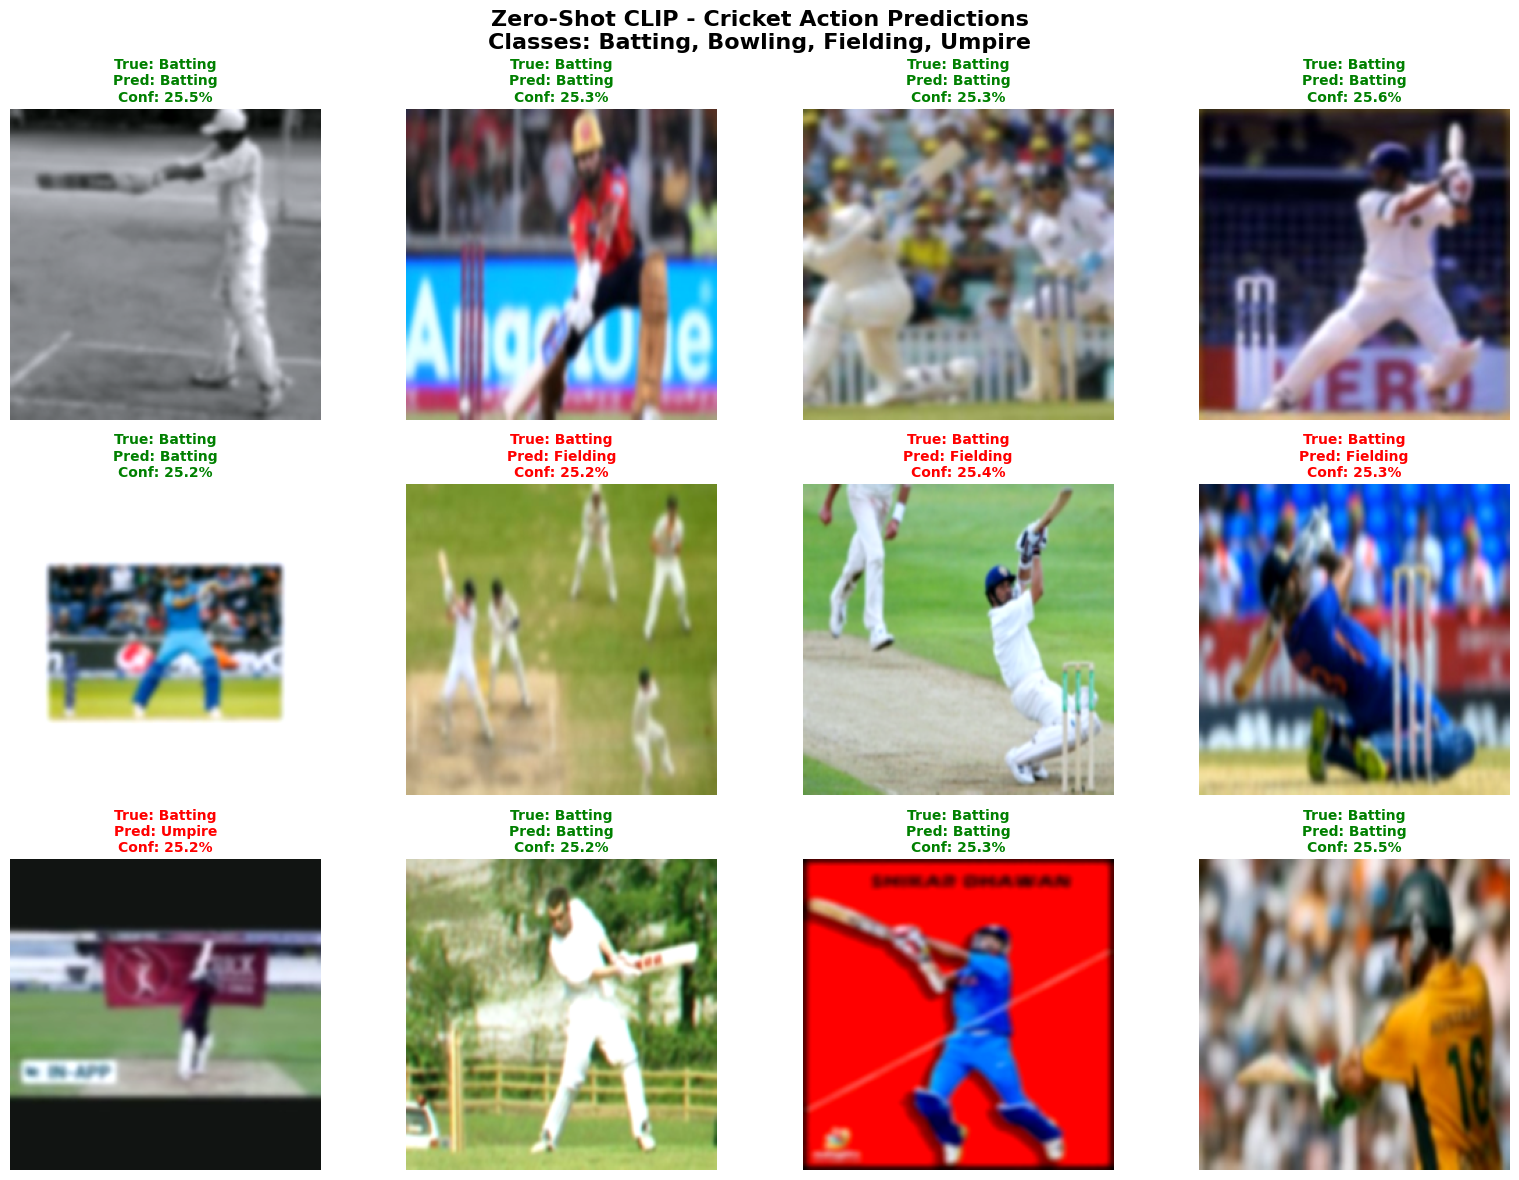

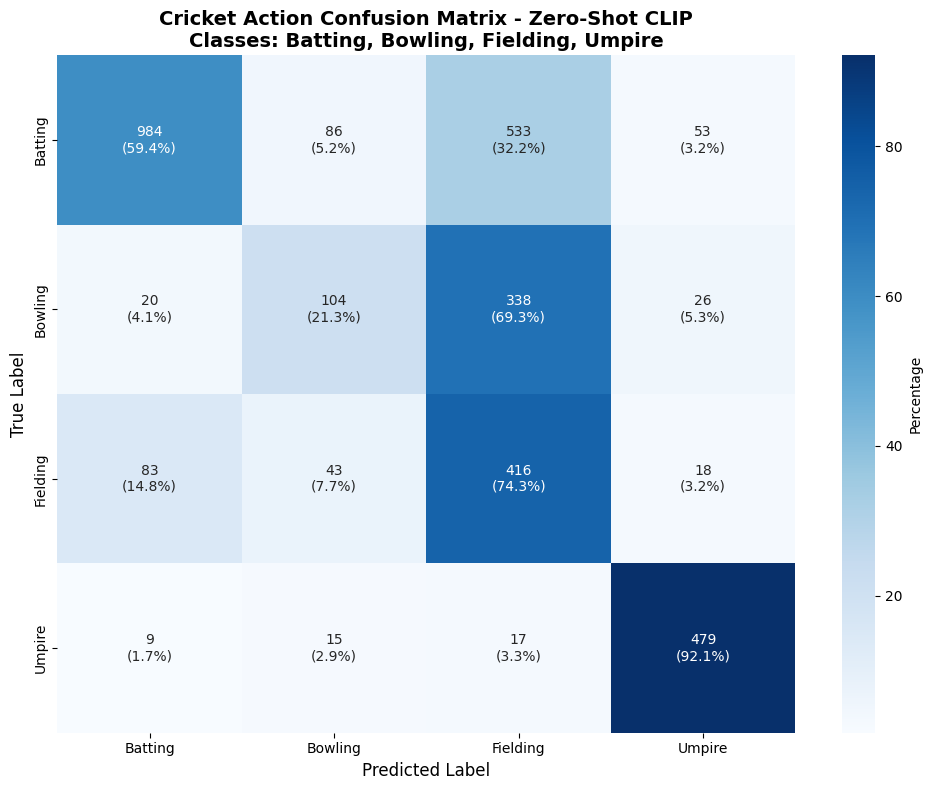


2️⃣ PRETRAINED CLIP WITH TEXT GUIDANCE (DTYPE FIXED)
🔧 Converting CLIP model to float32...
✅ CLIP model converted to float32
📊 Trainable parameter dtypes:
│ temperature: torch.float32
│ classifier.1.weight: torch.float32
│ classifier.1.bias: torch.float32
│ classifier.3.weight: torch.float32
│ classifier.3.bias: torch.float32
│ classifier.5.weight: torch.float32
│ classifier.5.bias: torch.float32
│ classifier.7.weight: torch.float32
│ classifier.7.bias: torch.float32
│ classifier.9.weight: torch.float32
│ classifier.9.bias: torch.float32
│ classifier.12.weight: torch.float32
│ classifier.12.bias: torch.float32
│ text_guided_projection.0.weight: torch.float32
│ text_guided_projection.0.bias: torch.float32
│ text_guided_projection.3.weight: torch.float32
│ text_guided_projection.3.bias: torch.float32
🚀 Training CLIP Text Guided with Text Guidance...
📋 Using text prompts for classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']

📅 Epoch 1/50


Training: 100%|██████████| 311/311 [02:18<00:00,  2.24it/s, Loss=0.9393, Acc=68.19%]


✅ Best validation accuracy: 83.54%
📊 Train: 0.9393, 68.19% | Val: 0.7188, 83.54%

📅 Epoch 2/50


Training: 100%|██████████| 311/311 [01:28<00:00,  3.50it/s, Loss=0.8049, Acc=74.51%]


✅ Best validation accuracy: 85.40%
📊 Train: 0.8049, 74.51% | Val: 0.6360, 85.40%

📅 Epoch 3/50


Training: 100%|██████████| 311/311 [01:28<00:00,  3.50it/s, Loss=0.7879, Acc=75.39%]


✅ Best validation accuracy: 86.30%
📊 Train: 0.7879, 75.39% | Val: 0.6284, 86.30%

📅 Epoch 4/50


Training: 100%|██████████| 311/311 [01:29<00:00,  3.49it/s, Loss=0.7714, Acc=75.92%]


✅ Best validation accuracy: 88.20%
📊 Train: 0.7714, 75.92% | Val: 0.6020, 88.20%

📅 Epoch 5/50


Training: 100%|██████████| 311/311 [01:28<00:00,  3.52it/s, Loss=0.7551, Acc=77.04%]


📊 Train: 0.7551, 77.04% | Val: 0.6548, 87.00%

📅 Epoch 6/50


Training: 100%|██████████| 311/311 [01:28<00:00,  3.53it/s, Loss=0.7505, Acc=77.62%]


📊 Train: 0.7505, 77.62% | Val: 0.6159, 87.31%

📅 Epoch 7/50


Training: 100%|██████████| 311/311 [01:27<00:00,  3.55it/s, Loss=0.7442, Acc=77.28%]


📊 Train: 0.7442, 77.28% | Val: 0.6202, 87.97%

📅 Epoch 8/50


Training: 100%|██████████| 311/311 [01:27<00:00,  3.54it/s, Loss=0.7240, Acc=78.61%]


📊 Train: 0.7240, 78.61% | Val: 0.6038, 87.97%

📅 Epoch 9/50


Training: 100%|██████████| 311/311 [01:28<00:00,  3.51it/s, Loss=0.7148, Acc=78.85%]


✅ Best validation accuracy: 88.24%
📊 Train: 0.7148, 78.85% | Val: 0.6197, 88.24%

📅 Epoch 10/50


Training: 100%|██████████| 311/311 [01:28<00:00,  3.52it/s, Loss=0.7073, Acc=79.46%]


📊 Train: 0.7073, 79.46% | Val: 0.6386, 87.81%

📅 Epoch 11/50


Training: 100%|██████████| 311/311 [01:28<00:00,  3.52it/s, Loss=0.7073, Acc=79.44%]


✅ Best validation accuracy: 88.55%
📊 Train: 0.7073, 79.44% | Val: 0.5993, 88.55%

📅 Epoch 12/50


Training: 100%|██████████| 311/311 [01:25<00:00,  3.64it/s, Loss=0.7064, Acc=79.26%]


📊 Train: 0.7064, 79.26% | Val: 0.6257, 87.69%

📅 Epoch 13/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.70it/s, Loss=0.7020, Acc=79.36%]


📊 Train: 0.7020, 79.36% | Val: 0.6311, 88.00%

📅 Epoch 14/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.69it/s, Loss=0.7067, Acc=78.92%]


📊 Train: 0.7067, 78.92% | Val: 0.6119, 88.12%

📅 Epoch 15/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.68it/s, Loss=0.6866, Acc=80.31%]


📊 Train: 0.6866, 80.31% | Val: 0.6086, 87.85%

📅 Epoch 16/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.70it/s, Loss=0.6894, Acc=80.38%]


📊 Train: 0.6894, 80.38% | Val: 0.6017, 88.51%

📅 Epoch 17/50


Training: 100%|██████████| 311/311 [01:23<00:00,  3.71it/s, Loss=0.6863, Acc=80.77%]


📊 Train: 0.6863, 80.77% | Val: 0.6140, 87.97%

📅 Epoch 18/50


Training: 100%|██████████| 311/311 [01:23<00:00,  3.71it/s, Loss=0.6789, Acc=80.90%]


📊 Train: 0.6789, 80.90% | Val: 0.6159, 88.35%

📅 Epoch 19/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.70it/s, Loss=0.6735, Acc=81.27%]


📊 Train: 0.6735, 81.27% | Val: 0.6151, 88.28%

📅 Epoch 20/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.68it/s, Loss=0.6778, Acc=80.77%]


📊 Train: 0.6778, 80.77% | Val: 0.6182, 88.55%

📅 Epoch 21/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.67it/s, Loss=0.6731, Acc=81.32%]


✅ Best validation accuracy: 88.59%
📊 Train: 0.6731, 81.32% | Val: 0.6157, 88.59%

📅 Epoch 22/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.66it/s, Loss=0.6687, Acc=81.54%]


✅ Best validation accuracy: 89.01%
📊 Train: 0.6687, 81.54% | Val: 0.6189, 89.01%

📅 Epoch 23/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.69it/s, Loss=0.6655, Acc=81.22%]


📊 Train: 0.6655, 81.22% | Val: 0.6122, 88.78%

📅 Epoch 24/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.68it/s, Loss=0.6654, Acc=81.64%]


📊 Train: 0.6654, 81.64% | Val: 0.6235, 88.39%

📅 Epoch 25/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.69it/s, Loss=0.6656, Acc=81.52%]


📊 Train: 0.6656, 81.52% | Val: 0.6207, 88.82%

📅 Epoch 26/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.67it/s, Loss=0.6599, Acc=81.80%]


📊 Train: 0.6599, 81.80% | Val: 0.6235, 88.39%

📅 Epoch 27/50


Training: 100%|██████████| 311/311 [01:23<00:00,  3.71it/s, Loss=0.6576, Acc=82.03%]


📊 Train: 0.6576, 82.03% | Val: 0.6321, 87.85%

📅 Epoch 28/50


Training: 100%|██████████| 311/311 [01:23<00:00,  3.71it/s, Loss=0.6560, Acc=82.18%]


📊 Train: 0.6560, 82.18% | Val: 0.6285, 88.78%

📅 Epoch 29/50


Training: 100%|██████████| 311/311 [01:23<00:00,  3.73it/s, Loss=0.6627, Acc=81.54%]


📊 Train: 0.6627, 81.54% | Val: 0.6237, 88.55%

📅 Epoch 30/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.69it/s, Loss=0.6561, Acc=81.86%]


📊 Train: 0.6561, 81.86% | Val: 0.6276, 88.35%

📅 Epoch 31/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.70it/s, Loss=0.6529, Acc=82.10%]


📊 Train: 0.6529, 82.10% | Val: 0.6323, 88.39%

📅 Epoch 32/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.68it/s, Loss=0.6531, Acc=81.99%]


📊 Train: 0.6531, 81.99% | Val: 0.6351, 88.39%

📅 Epoch 33/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.66it/s, Loss=0.6588, Acc=81.59%]


📊 Train: 0.6588, 81.59% | Val: 0.6309, 88.32%

📅 Epoch 34/50


Training: 100%|██████████| 311/311 [01:25<00:00,  3.64it/s, Loss=0.6510, Acc=82.50%]


📊 Train: 0.6510, 82.50% | Val: 0.6369, 88.24%

📅 Epoch 35/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.66it/s, Loss=0.6549, Acc=81.87%]


📊 Train: 0.6549, 81.87% | Val: 0.6368, 87.93%

📅 Epoch 36/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.67it/s, Loss=0.6533, Acc=82.05%]


📊 Train: 0.6533, 82.05% | Val: 0.6364, 88.20%

📅 Epoch 37/50


Training: 100%|██████████| 311/311 [01:25<00:00,  3.63it/s, Loss=0.6545, Acc=82.01%]


📊 Train: 0.6545, 82.01% | Val: 0.6347, 88.12%

📅 Epoch 38/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.67it/s, Loss=0.6571, Acc=81.59%]


📊 Train: 0.6571, 81.59% | Val: 0.6343, 88.51%

📅 Epoch 39/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.67it/s, Loss=0.6567, Acc=81.86%]


📊 Train: 0.6567, 81.86% | Val: 0.6374, 88.16%

📅 Epoch 40/50


Training: 100%|██████████| 311/311 [01:27<00:00,  3.56it/s, Loss=0.6492, Acc=82.19%]


📊 Train: 0.6492, 82.19% | Val: 0.6362, 88.24%

📅 Epoch 41/50


Training: 100%|██████████| 311/311 [01:26<00:00,  3.59it/s, Loss=0.6491, Acc=82.29%]


📊 Train: 0.6491, 82.29% | Val: 0.6379, 88.24%

📅 Epoch 42/50


Training: 100%|██████████| 311/311 [01:25<00:00,  3.62it/s, Loss=0.6485, Acc=82.58%]


📊 Train: 0.6485, 82.58% | Val: 0.6445, 87.97%

📅 Epoch 43/50


Training: 100%|██████████| 311/311 [01:26<00:00,  3.59it/s, Loss=0.6562, Acc=81.82%]


📊 Train: 0.6562, 81.82% | Val: 0.6410, 88.04%

📅 Epoch 44/50


Training: 100%|██████████| 311/311 [01:25<00:00,  3.66it/s, Loss=0.6515, Acc=82.33%]


📊 Train: 0.6515, 82.33% | Val: 0.6433, 87.89%

📅 Epoch 45/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.67it/s, Loss=0.6511, Acc=82.06%]


📊 Train: 0.6511, 82.06% | Val: 0.6418, 88.00%

📅 Epoch 46/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.67it/s, Loss=0.6457, Acc=82.73%]


📊 Train: 0.6457, 82.73% | Val: 0.6438, 88.08%

📅 Epoch 47/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.69it/s, Loss=0.6473, Acc=82.41%]


📊 Train: 0.6473, 82.41% | Val: 0.6390, 88.12%

📅 Epoch 48/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.66it/s, Loss=0.6473, Acc=82.19%]


📊 Train: 0.6473, 82.19% | Val: 0.6455, 87.93%

📅 Epoch 49/50


Training: 100%|██████████| 311/311 [01:24<00:00,  3.69it/s, Loss=0.6482, Acc=82.41%]


📊 Train: 0.6482, 82.41% | Val: 0.6378, 88.39%

📅 Epoch 50/50


Training: 100%|██████████| 311/311 [01:25<00:00,  3.65it/s, Loss=0.6492, Acc=82.34%]


📊 Train: 0.6492, 82.34% | Val: 0.6413, 88.24%

🔍 Evaluating CLIP Text Guided...
📋 Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']


Testing: 100%|██████████| 101/101 [00:29<00:00,  3.45it/s]


🎯 CLIP Text Guided Accuracy: 0.9035 (90.35%)
📋 Classification Report:
              precision    recall  f1-score   support

     Batting     0.9303    0.9505    0.9403      1656
     Bowling     0.8498    0.8463    0.8480       488
    Fielding     0.8156    0.7821    0.7985       560
      Umpire     0.9587    0.9385    0.9485       520

    accuracy                         0.9035      3224
   macro avg     0.8886    0.8793    0.8838      3224
weighted avg     0.9028    0.9035    0.9030      3224



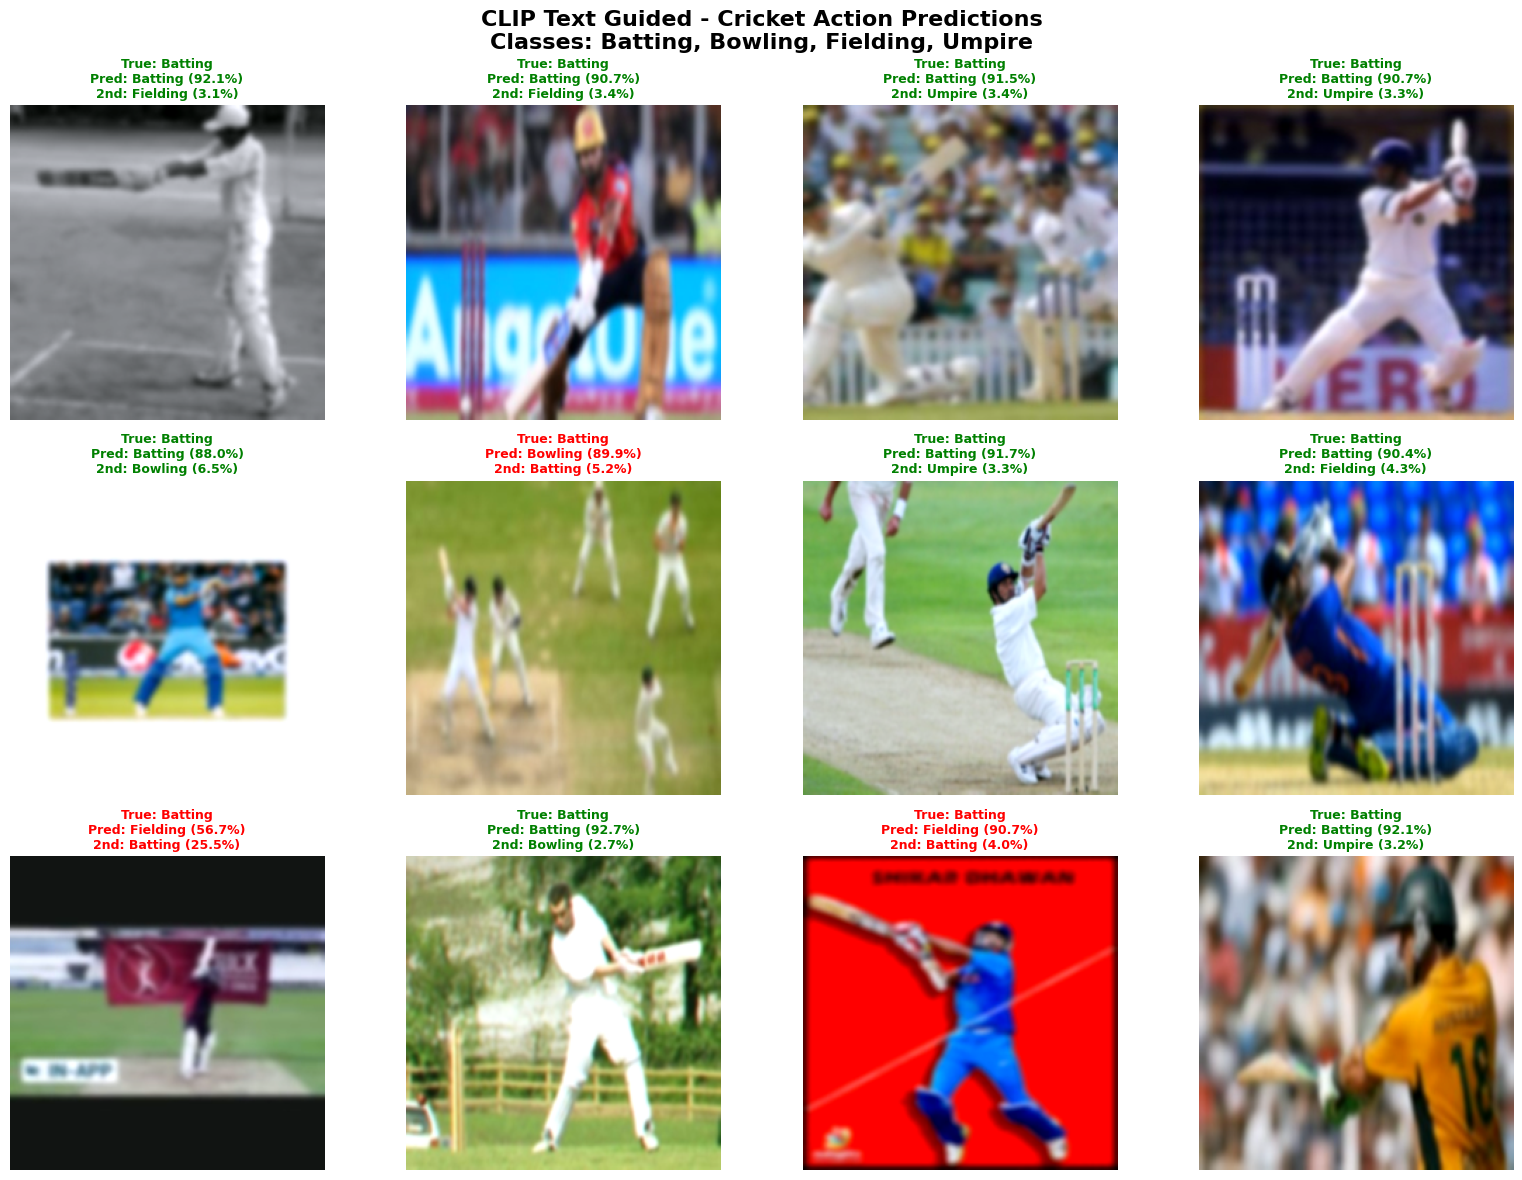

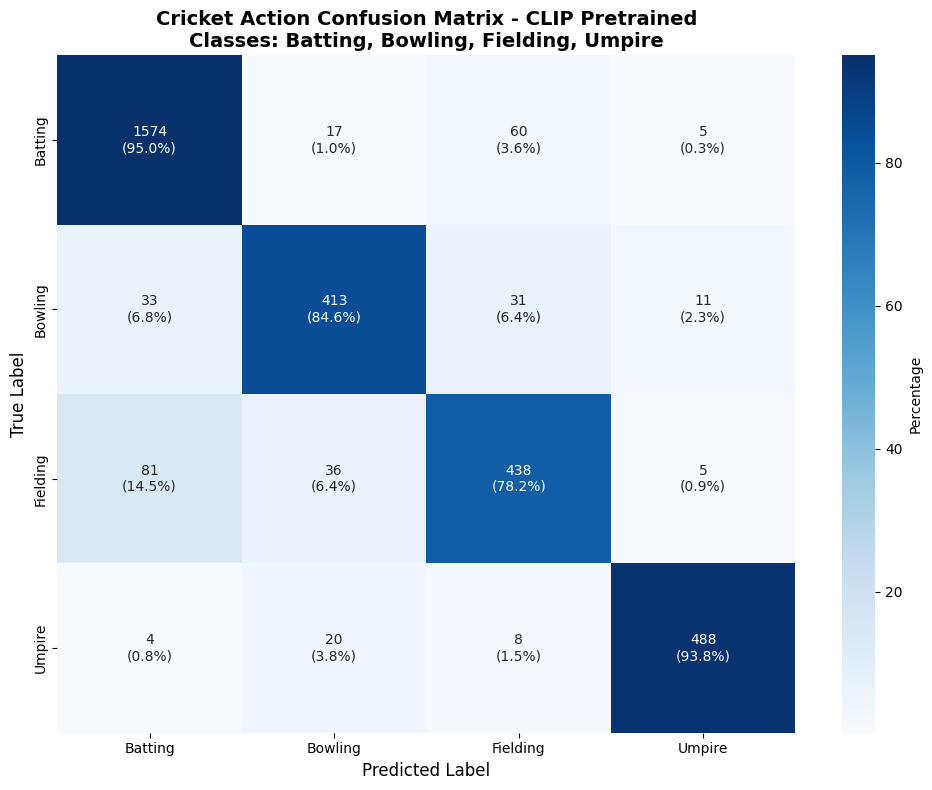


3️⃣ VISION TRANSFORMER FROM SCRATCH WITH TEXT SUPERVISION
🚀 Training ViT Text Supervised with Text Supervision...

📅 Epoch 1/50


Training: 100%|██████████| 311/311 [02:55<00:00,  1.77it/s, Loss=1.1395, Acc=54.76%]


✅ Best validation accuracy: 56.41%
📊 Train Acc: 54.76% | Val Acc: 56.41%

📅 Epoch 2/50


Training: 100%|██████████| 311/311 [02:54<00:00,  1.78it/s, Loss=0.9677, Acc=65.72%]


✅ Best validation accuracy: 58.23%
📊 Train Acc: 65.72% | Val Acc: 58.23%

📅 Epoch 3/50


Training: 100%|██████████| 311/311 [02:53<00:00,  1.79it/s, Loss=0.7629, Acc=79.00%]


✅ Best validation accuracy: 65.49%
📊 Train Acc: 79.00% | Val Acc: 65.49%

📅 Epoch 4/50


Training: 100%|██████████| 311/311 [02:53<00:00,  1.79it/s, Loss=0.5957, Acc=88.07%]


📊 Train Acc: 88.07% | Val Acc: 64.79%

📅 Epoch 5/50


Training: 100%|██████████| 311/311 [02:54<00:00,  1.79it/s, Loss=0.5263, Acc=91.69%]


📊 Train Acc: 91.69% | Val Acc: 63.24%

📅 Epoch 6/50


Training: 100%|██████████| 311/311 [02:53<00:00,  1.79it/s, Loss=0.4945, Acc=93.51%]


📊 Train Acc: 93.51% | Val Acc: 64.25%

📅 Epoch 7/50


Training: 100%|██████████| 311/311 [02:54<00:00,  1.78it/s, Loss=0.4664, Acc=94.73%]


📊 Train Acc: 94.73% | Val Acc: 63.98%

📅 Epoch 8/50


Training: 100%|██████████| 311/311 [02:53<00:00,  1.79it/s, Loss=0.4522, Acc=95.44%]


✅ Best validation accuracy: 66.50%
📊 Train Acc: 95.44% | Val Acc: 66.50%

📅 Epoch 9/50


Training: 100%|██████████| 311/311 [02:53<00:00,  1.79it/s, Loss=0.4387, Acc=95.94%]


✅ Best validation accuracy: 67.51%
📊 Train Acc: 95.94% | Val Acc: 67.51%

📅 Epoch 10/50


Training: 100%|██████████| 311/311 [02:58<00:00,  1.74it/s, Loss=0.4191, Acc=96.97%]


📊 Train Acc: 96.97% | Val Acc: 66.50%

📅 Epoch 11/50


Training: 100%|██████████| 311/311 [02:58<00:00,  1.74it/s, Loss=0.4190, Acc=97.07%]


✅ Best validation accuracy: 71.04%
📊 Train Acc: 97.07% | Val Acc: 71.04%

📅 Epoch 12/50


Training: 100%|██████████| 311/311 [02:59<00:00,  1.73it/s, Loss=0.4170, Acc=97.07%]


📊 Train Acc: 97.07% | Val Acc: 68.56%

📅 Epoch 13/50


Training: 100%|██████████| 311/311 [02:59<00:00,  1.74it/s, Loss=0.4022, Acc=97.78%]


📊 Train Acc: 97.78% | Val Acc: 68.17%

📅 Epoch 14/50


Training: 100%|██████████| 311/311 [02:58<00:00,  1.74it/s, Loss=0.3902, Acc=98.37%]


📊 Train Acc: 98.37% | Val Acc: 65.80%

📅 Epoch 15/50


Training: 100%|██████████| 311/311 [02:58<00:00,  1.74it/s, Loss=0.3896, Acc=98.36%]


📊 Train Acc: 98.36% | Val Acc: 66.23%

📅 Epoch 16/50


Training: 100%|██████████| 311/311 [02:59<00:00,  1.73it/s, Loss=0.3904, Acc=98.36%]


📊 Train Acc: 98.36% | Val Acc: 69.18%

📅 Epoch 17/50


Training: 100%|██████████| 311/311 [02:58<00:00,  1.74it/s, Loss=0.3943, Acc=98.02%]


📊 Train Acc: 98.02% | Val Acc: 67.16%

📅 Epoch 18/50


Training: 100%|██████████| 311/311 [02:59<00:00,  1.74it/s, Loss=0.3825, Acc=98.64%]


📊 Train Acc: 98.64% | Val Acc: 68.28%

📅 Epoch 19/50


Training: 100%|██████████| 311/311 [02:59<00:00,  1.73it/s, Loss=0.3760, Acc=98.88%]


📊 Train Acc: 98.88% | Val Acc: 68.79%

📅 Epoch 20/50


Training: 100%|██████████| 311/311 [02:58<00:00,  1.74it/s, Loss=0.3739, Acc=98.96%]


📊 Train Acc: 98.96% | Val Acc: 70.34%

📅 Epoch 21/50


Training: 100%|██████████| 311/311 [02:59<00:00,  1.73it/s, Loss=0.3714, Acc=99.11%]


📊 Train Acc: 99.11% | Val Acc: 68.87%

📅 Epoch 22/50


Training: 100%|██████████| 311/311 [02:59<00:00,  1.74it/s, Loss=0.3725, Acc=99.09%]


📊 Train Acc: 99.09% | Val Acc: 67.86%

📅 Epoch 23/50


Training: 100%|██████████| 311/311 [02:58<00:00,  1.74it/s, Loss=0.3698, Acc=99.12%]


📊 Train Acc: 99.12% | Val Acc: 68.44%

📅 Epoch 24/50


Training: 100%|██████████| 311/311 [02:58<00:00,  1.75it/s, Loss=0.3616, Acc=99.48%]


📊 Train Acc: 99.48% | Val Acc: 70.19%

📅 Epoch 25/50


Training: 100%|██████████| 311/311 [03:00<00:00,  1.73it/s, Loss=0.3592, Acc=99.61%]


📊 Train Acc: 99.61% | Val Acc: 69.64%

📅 Epoch 26/50


Training: 100%|██████████| 311/311 [02:59<00:00,  1.73it/s, Loss=0.3630, Acc=99.44%]


📊 Train Acc: 99.44% | Val Acc: 67.47%

📅 Epoch 27/50


Training: 100%|██████████| 311/311 [03:00<00:00,  1.73it/s, Loss=0.3594, Acc=99.56%]


📊 Train Acc: 99.56% | Val Acc: 70.57%

📅 Epoch 28/50


Training: 100%|██████████| 311/311 [02:58<00:00,  1.74it/s, Loss=0.3573, Acc=99.68%]


📊 Train Acc: 99.68% | Val Acc: 68.21%

📅 Epoch 29/50


Training: 100%|██████████| 311/311 [03:00<00:00,  1.73it/s, Loss=0.3528, Acc=99.88%]


📊 Train Acc: 99.88% | Val Acc: 69.53%

📅 Epoch 30/50


Training: 100%|██████████| 311/311 [02:59<00:00,  1.73it/s, Loss=0.3638, Acc=99.44%]


📊 Train Acc: 99.44% | Val Acc: 70.50%

📅 Epoch 31/50


Training: 100%|██████████| 311/311 [03:00<00:00,  1.72it/s, Loss=0.3546, Acc=99.79%]


📊 Train Acc: 99.79% | Val Acc: 70.73%

📅 Epoch 32/50


Training: 100%|██████████| 311/311 [02:59<00:00,  1.73it/s, Loss=0.3561, Acc=99.75%]


📊 Train Acc: 99.75% | Val Acc: 69.99%

📅 Epoch 33/50


Training: 100%|██████████| 311/311 [02:55<00:00,  1.78it/s, Loss=0.3526, Acc=99.86%]


📊 Train Acc: 99.86% | Val Acc: 68.56%

📅 Epoch 34/50


Training: 100%|██████████| 311/311 [02:54<00:00,  1.78it/s, Loss=0.3525, Acc=99.83%]


📊 Train Acc: 99.83% | Val Acc: 70.96%

📅 Epoch 35/50


Training: 100%|██████████| 311/311 [02:55<00:00,  1.78it/s, Loss=0.3520, Acc=99.88%]


📊 Train Acc: 99.88% | Val Acc: 70.30%

📅 Epoch 36/50


Training: 100%|██████████| 311/311 [02:55<00:00,  1.77it/s, Loss=0.3500, Acc=99.96%]


📊 Train Acc: 99.96% | Val Acc: 68.67%

📅 Epoch 37/50


Training: 100%|██████████| 311/311 [02:55<00:00,  1.78it/s, Loss=0.3503, Acc=99.95%]


📊 Train Acc: 99.95% | Val Acc: 70.65%

📅 Epoch 38/50


Training: 100%|██████████| 311/311 [02:55<00:00,  1.77it/s, Loss=0.3500, Acc=99.95%]


📊 Train Acc: 99.95% | Val Acc: 70.57%

📅 Epoch 39/50


Training: 100%|██████████| 311/311 [02:55<00:00,  1.77it/s, Loss=0.3495, Acc=99.99%]


📊 Train Acc: 99.99% | Val Acc: 70.19%

📅 Epoch 40/50


Training: 100%|██████████| 311/311 [02:54<00:00,  1.78it/s, Loss=0.3498, Acc=99.97%]


📊 Train Acc: 99.97% | Val Acc: 70.89%

📅 Epoch 41/50


Training: 100%|██████████| 311/311 [02:54<00:00,  1.78it/s, Loss=0.3499, Acc=99.97%]


📊 Train Acc: 99.97% | Val Acc: 69.18%

📅 Epoch 42/50


Training: 100%|██████████| 311/311 [02:55<00:00,  1.77it/s, Loss=0.3505, Acc=99.94%]


📊 Train Acc: 99.94% | Val Acc: 69.95%

📅 Epoch 43/50


Training: 100%|██████████| 311/311 [02:54<00:00,  1.78it/s, Loss=0.3496, Acc=99.97%]


📊 Train Acc: 99.97% | Val Acc: 69.60%

📅 Epoch 44/50


Training: 100%|██████████| 311/311 [02:54<00:00,  1.78it/s, Loss=0.3493, Acc=99.98%]


📊 Train Acc: 99.98% | Val Acc: 69.45%

📅 Epoch 45/50


Training: 100%|██████████| 311/311 [02:55<00:00,  1.77it/s, Loss=0.3491, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 69.53%

📅 Epoch 46/50


Training: 100%|██████████| 311/311 [02:54<00:00,  1.78it/s, Loss=0.3491, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 69.53%

📅 Epoch 47/50


Training: 100%|██████████| 311/311 [02:55<00:00,  1.77it/s, Loss=0.3491, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 69.53%

📅 Epoch 48/50


Training: 100%|██████████| 311/311 [02:54<00:00,  1.78it/s, Loss=0.3491, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 69.53%

📅 Epoch 49/50


Training: 100%|██████████| 311/311 [02:54<00:00,  1.78it/s, Loss=0.3491, Acc=100.00%]


📊 Train Acc: 100.00% | Val Acc: 69.49%

📅 Epoch 50/50


Training: 100%|██████████| 311/311 [02:55<00:00,  1.78it/s, Loss=0.3494, Acc=99.99%]


📊 Train Acc: 99.99% | Val Acc: 69.53%

🔍 Evaluating ViT Text Supervised...
📋 Classes: ['Batting', 'Bowling', 'Fielding', 'Umpire']


Testing: 100%|██████████| 101/101 [00:30<00:00,  3.27it/s]


🎯 ViT Text Supervised Accuracy: 0.6780 (67.80%)
📋 Classification Report:
              precision    recall  f1-score   support

     Batting     0.7214    0.8786    0.7923      1656
     Bowling     0.5392    0.3525    0.4263       488
    Fielding     0.5345    0.5536    0.5439       560
      Umpire     0.8084    0.4788    0.6014       520

    accuracy                         0.6780      3224
   macro avg     0.6509    0.5659    0.5910      3224
weighted avg     0.6754    0.6780    0.6629      3224



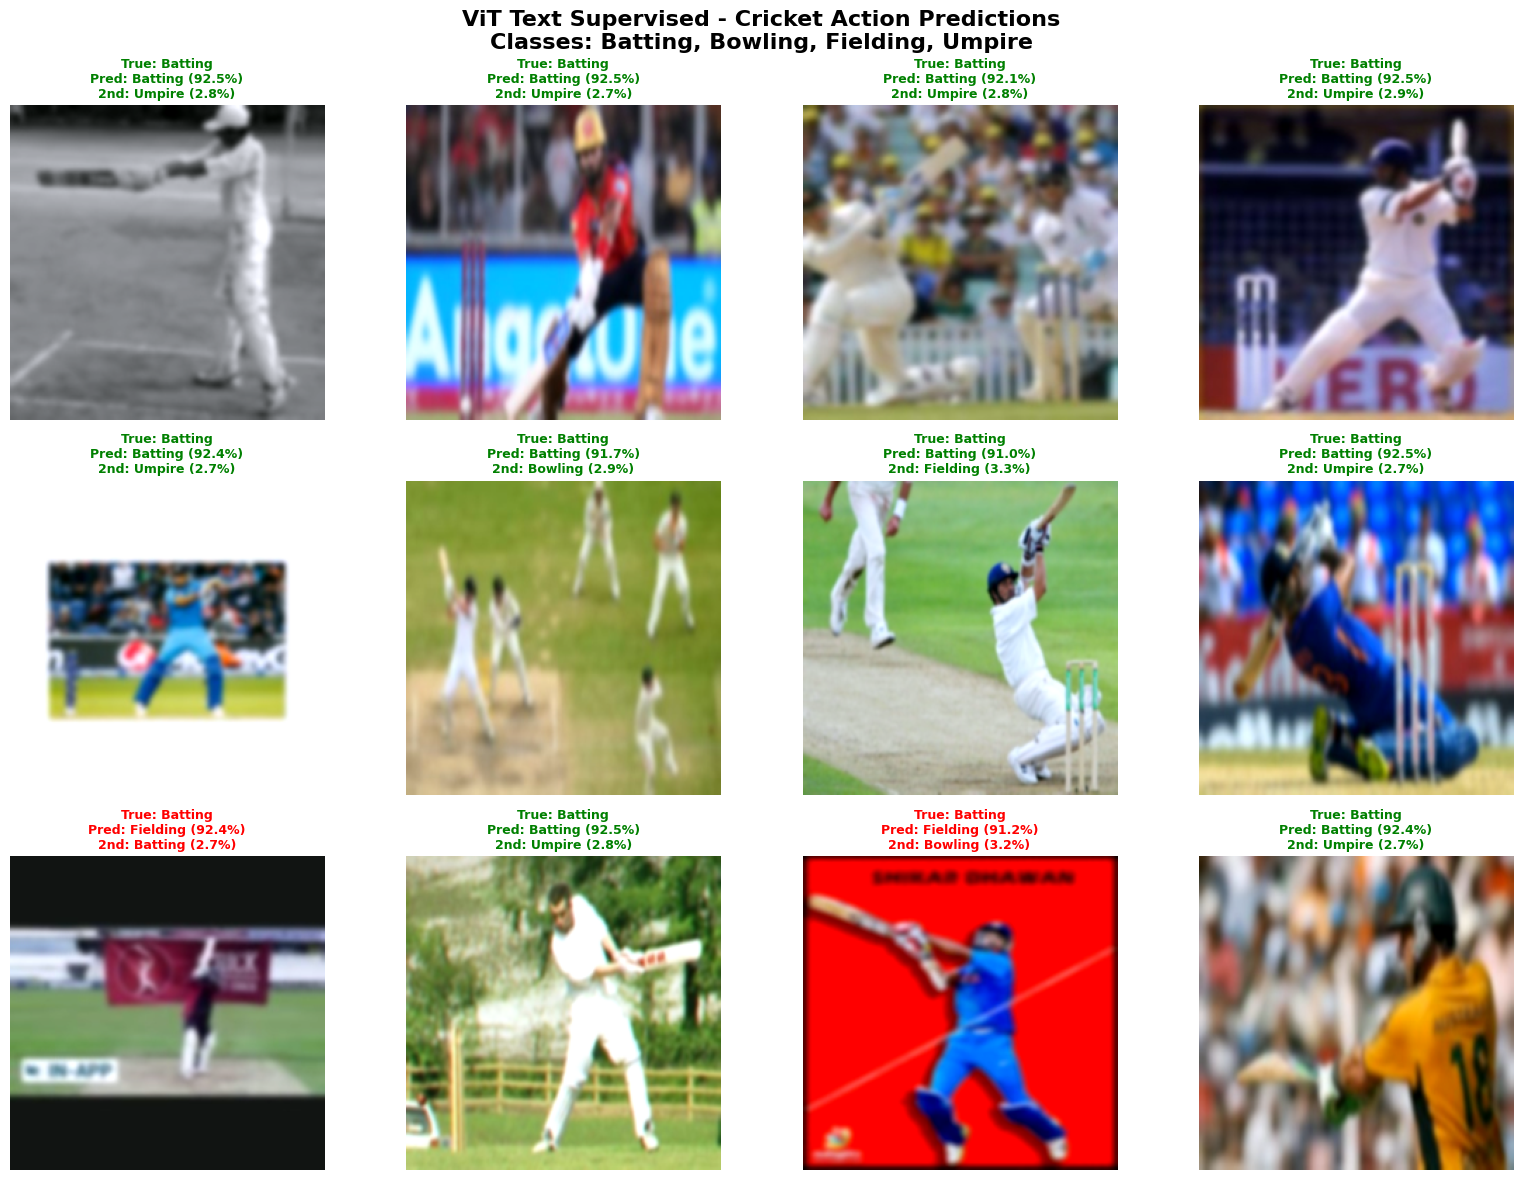

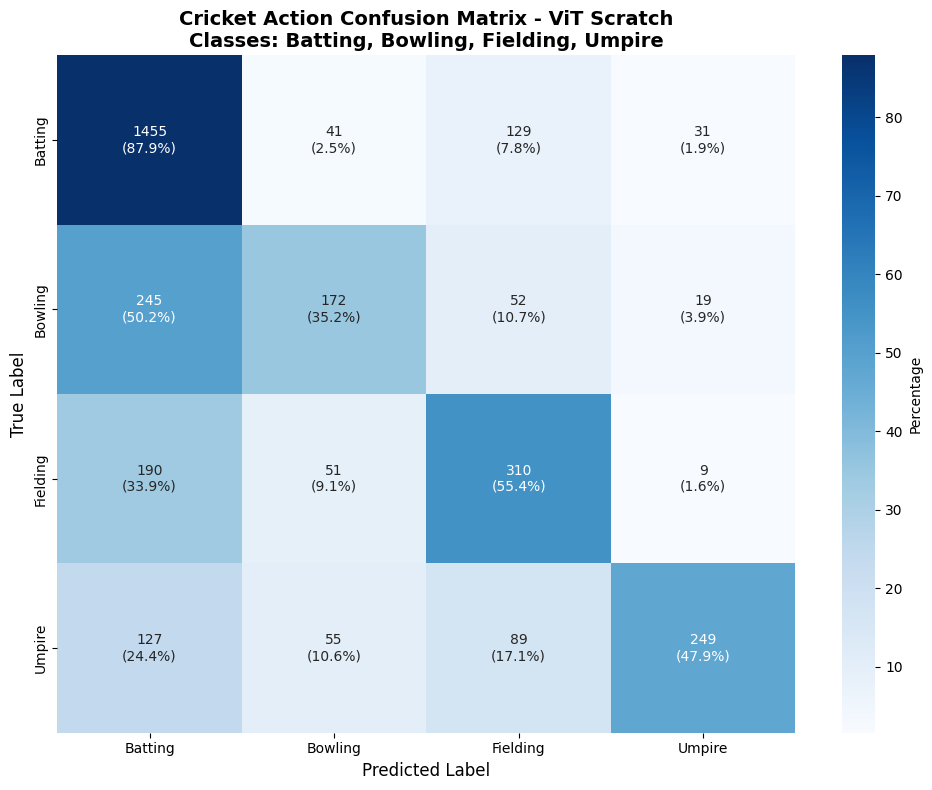


📊 FINAL RESULTS - CRICKET ACTION CLASSIFICATION (DTYPE FIXED)


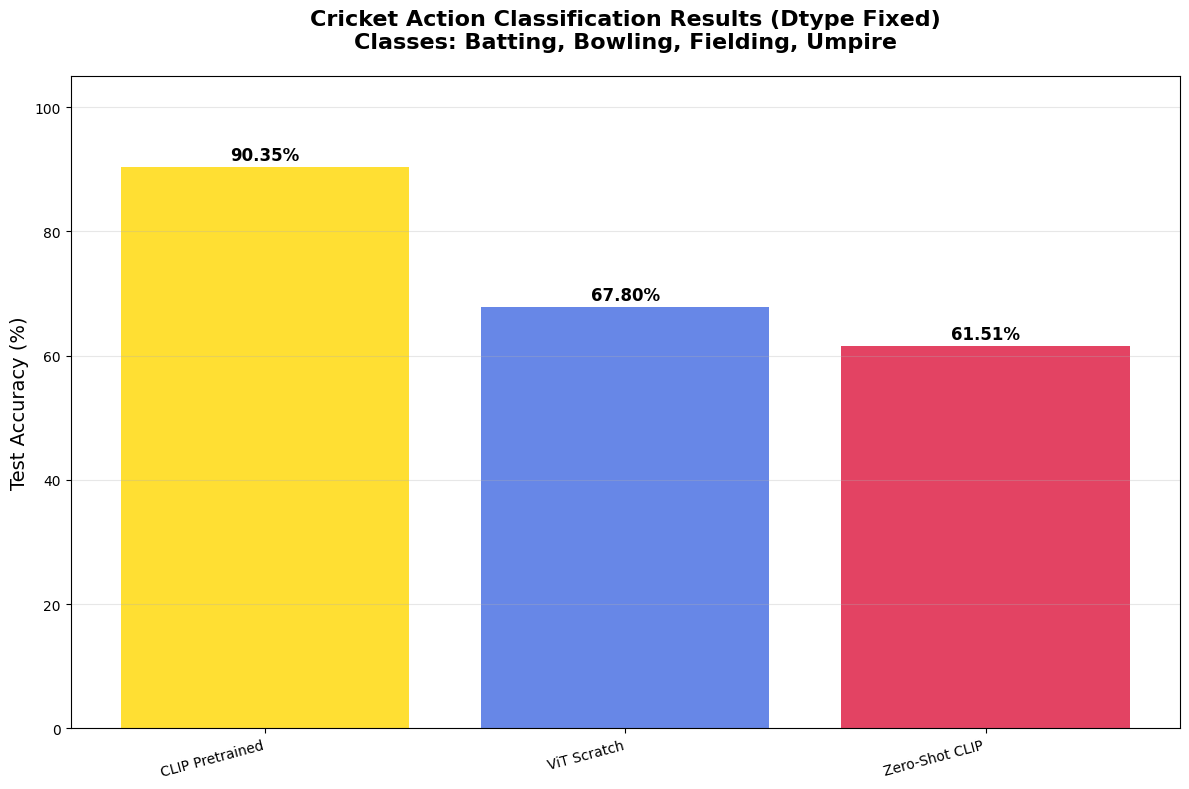

🏆 FINAL RANKINGS:
🥇 CLIP Pretrained: 0.9035 (90.35%)
🥈 ViT Scratch: 0.6780 (67.80%)
🥉 Zero-Shot CLIP: 0.6151 (61.51%)

📈 Performance Range: 46.90% improvement from worst to best

✨ TEXT ENHANCEMENT BENEFITS:
│ 🎯 Semantic Understanding: Models learn explicit action descriptions
│ 🔄 Multi-Modal Learning: Combines visual and textual information
│ 📈 Better Generalization: Text guidance improves robustness
│ 🎨 Interpretability: Clear text-image associations
│ 🚀 Faster Convergence: Text supervision accelerates learning

✅ Cricket Action Classification Complete (Dtype Fixed)!
🔧 All dtype mismatches resolved
📋 Classes processed: ['Batting', 'Bowling', 'Fielding', 'Umpire']
📁 Generated Files:
│ zero-shot_clip_cricket_predictions.png
│ clip_text_guided_cricket_predictions.png
│ vit_text_supervised_cricket_predictions.png
│ zero-shot_clip_confusion_matrix.png
│ clip_pretrained_confusion_matrix.png
│ vit_scratch_confusion_matrix.png
│ cricket_action_final_results_fixed.png


In [9]:
results = run_cricket_action_classification_with_text_fixed(train_loader, val_loader, test_loader)